In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from astropy.time import Time
from astropy.table import Table
from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from astropy.time import Time

In [2]:
obs = pd.read_csv("data/nu_alerts_observed.csv", skiprows=[0, 1, 2])

obs = obs[~np.isnan(obs["RA"])]

non = pd.read_csv("data/nu_alerts_unobserved.csv", skiprows=[0, 1], usecols=range(11))

In [3]:
relabels = {
    "Alert retraction": "Alert Retraction",
    "Proximity to sun": "Proximity to Sun",
    "Separation from galactic plane": "Separation from Galactic Plane",
    "Poor Signalness and Localization": "Poor Signalness and Localisation"
}

for key, new in relabels.items():
    print(key, new)
    mask = non["Rejection reason"] == key
    non["Rejection reason"][mask] = new


Alert retraction Alert Retraction
Proximity to sun Proximity to Sun
Separation from galactic plane Separation from Galactic Plane
Poor Signalness and Localization Poor Signalness and Localisation


/var/folders/_g/r6hjlm8j6mqcvr1yzq2dlzz40000gn/T/ipykernel_34126/1941142432.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non["Rejection reason"][mask] = new


# Alert Statistics

['Observed', 'Alert Retraction', 'Low Altitude', 'Poor Signalness \n and Localisation', 'Proximity to Sun', 'Separation from Galactic Plane', 'Southern Sky', 'Telescope Maintenance']


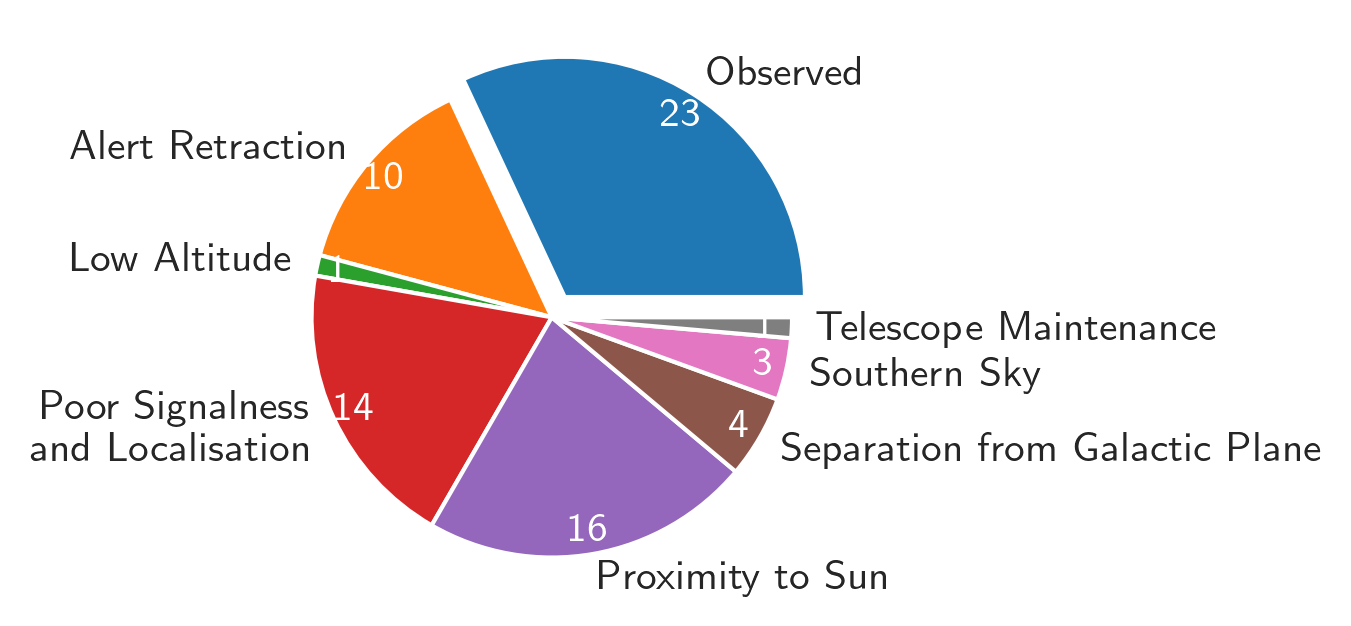

In [4]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

reasons = [x if x != "Poor Signalness and Localisation" else "Poor Signalness \n and Localisation" for x in non["Rejection reason"]]

reasons = [x for i, x in enumerate(reasons) if float(non["Event"][i][2:6]) > 1803]
labels = sorted(list(set(reasons)))

sizes = []

for l in labels:
    sizes.append(list(reasons).count(l))
    
explode =[0.1] + [0.0 for _ in labels]

labels = ["Observed"] + labels
sizes = [len(obs)] + sizes

def absolute_value(val):
    a  = np.round(val/100.*np.sum(sizes), 0)
    return int(a)

print(labels)

patches, texts, autotexts = ax1.pie(sizes, 
                                    explode=explode, 
                                    labels=labels, 
                                    autopct=absolute_value,
                                    pctdistance=0.9,
                                    textprops={'fontsize': big_fontsize}
                                   )

[autotext.set_color('white') for autotext in autotexts]


ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

filename = "pie.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)


# Observed alerts (Table 1)

In [5]:
text = r"""
\begin{table*}
\centering
    \begin{tabular}{||c | c c c c c c ||} 
         \hline
         \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} & \textbf{ZTF obs} &~ \textbf{Signalness}& \textbf{Refs}\\
         & \textbf{[deg]}&\textbf{[deg]}& \textbf{[sq. deg.]}& \textbf{[sq. deg.]} &&\\
         \hline
"""

tot_area = 0.

for index, row in obs.iterrows():
    
    name = str(row["Event"].lower())
        
    ras = json.loads(row["RA Unc (rectangle)"])
    
    decs = json.loads(row["Dec Unc (rectangle)"])    
    
    delta_r = ras[0] - ras[1]
    delta_d = decs[0] - decs[1]
    
    area = delta_r * delta_d  * np.cos(np.radians(float(row["Dec"])))
    
    if np.isnan(float(row["Signalness"])):
        s = "-"
    else:
        s = f'{100.*row["Signalness"]:.0f}\%'
                    
    text += f'\t {row["Event"]} & {row["RA"]} & {row["Dec"]:+.2f} & {area:.1f} & {row["Observed area (corrected for chip gaps)"]:.1f} & {s} & \cite{{{name}}} \\\\\ \n'

    text += f'\t &&&&&& \cite{{{name}_ztf}} \\\\ \n'
    if not isinstance(row["Additional ZTF GCN"], float):
        text += f'\t &&&&&& \cite{{{name}_ztf_2}} \\\\ \n'
    
    text += "\t \hline"
    
    tot_area += row["Observed area (corrected for chip gaps)"]

text += f"""
    \end{{tabular}}
    \caption{{Summary of the {len(obs)} neutrino alerts followed up by ZTF since survey start on 2018 March 20.}}
    \label{{tab:nu_alerts}}
\end{{table*}}
"""

print(text)


\begin{table*}
\centering
    \begin{tabular}{||c | c c c c c c ||} 
         \hline
         \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} & \textbf{ZTF obs} &~ \textbf{Signalness}& \textbf{Refs}\\
         & \textbf{[deg]}&\textbf{[deg]}& \textbf{[sq. deg.]}& \textbf{[sq. deg.]} &&\\
         \hline
	 IC190503A & 120.28 & +6.35 & 1.9 & 1.4 & 36\% & \cite{ic190503a} \\\ 
	 &&&&&& \cite{ic190503a_ztf} \\ 
	 \hline	 IC190619A & 343.26 & +10.73 & 27.2 & 21.6 & 55\% & \cite{ic190619a} \\\ 
	 &&&&&& \cite{ic190619a_ztf} \\ 
	 \hline	 IC190730A & 225.79 & +10.47 & 5.4 & 4.5 & 67\% & \cite{ic190730a} \\\ 
	 &&&&&& \cite{ic190730a_ztf} \\ 
	 \hline	 IC190922B & 5.76 & -1.57 & 4.5 & 4.1 & 51\% & \cite{ic190922b} \\\ 
	 &&&&&& \cite{ic190922b_ztf} \\ 
	 \hline	 IC191001A & 314.08 & +12.94 & 25.5 & 23.1 & 59\% & \cite{ic191001a} \\\ 
	 &&&&&& \cite{ic191001a_ztf} \\ 
	 \hline	 IC200107A & 148.18 & +35.46 & 7.6 & 6.3 & - & \cite{ic200107a} \\\ 
	 &&&&&& \cite

# Not observed

In [6]:
reasons = ["Alert Retraction", "Proximity to Sun", "Low Altitude", "Southern Sky", "Separation from Galactic Plane", "Poor Signalness and Localisation", "Telescope Maintenance"]
seps = [1, 0, 0, 0, 1, 1, 1]

full_mask = np.array([float(x[2:6]) > 1803 for x in non["Event"]])


text = r"""
\begin{table*}
    \centering
    \begin{tabular}{||c c ||} 
        \hline
        \textbf{Cause} & \textbf{Events} \\
        \hline
"""

for i, reason in enumerate(reasons):
    mask = non["Rejection reason"] == reason
    
    names = list(non["Event"][full_mask][mask])
    
    for j, name in enumerate(names):
        names[j] = f'{name} \cite{{{name.lower()}}}'
    
    text += f'\t {reason} & '
    
    n_int = 2
                 
    while len(names) > n_int:
        text += f'{", ".join(names[:n_int])} \\\\ \n \t & '
        names = names[n_int:]
        
    text += f'{", ".join(names)} \\\\ \n'

#     if seps[i]:
    if True:
        text += "\t \hline \n"
        
text +=f"""
    \end{{tabular}}
    \caption{{Summary of the {np.sum(full_mask)} neutrino alerts that were not followed up by ZTF since survey start on 2018 March 20.}}
    \label{{tab:nu_non_observed}}
\end{{table*}}
"""

print(text)


\begin{table*}
    \centering
    \begin{tabular}{||c c ||} 
        \hline
        \textbf{Cause} & \textbf{Events} \\
        \hline
	 Alert Retraction & IC180423A \cite{ic180423a}, IC181031A \cite{ic181031a} \\ 
 	 & IC190205A \cite{ic190205a}, IC190529A \cite{ic190529a} \\ 
 	 & IC200120A \cite{ic200120a}, IC200728A \cite{ic200728a} \\ 
 	 & IC201115B \cite{ic201115b}, IC210213A \cite{ic210213a} \\ 
 	 & IC210322A \cite{ic210322a}, IC210519A \cite{ic210519a} \\ 
	 \hline 
	 Proximity to Sun & IC180908A \cite{ic180908a}, IC181014A \cite{ic181014a} \\ 
 	 & IC190124A \cite{ic190124a}, IC190704A \cite{ic190704a} \\ 
 	 & IC190712A \cite{ic190712a}, IC190819A \cite{ic190819a} \\ 
 	 & IC191119A \cite{ic191119a}, IC200227A \cite{ic200227a} \\ 
 	 & IC200421A \cite{ic200421a}, IC200615A \cite{ic200615a} \\ 
 	 & IC200806A \cite{ic200806a}, IC200921A \cite{ic200921a} \\ 
 	 & IC200926B \cite{ic200926b}, IC201014A \cite{ic201014a} \\ 
 	 & IC201115A \cite{ic201115a}, IC201221A \cite{ic201

# Appendix table

In [7]:
joint = pd.concat([non, obs], axis=0).sort_values(by=['Event'])

text = fr"""
\begin{{longtable}}[c]{{||c c c c c c ||}}
\caption{{Summary of all {len(joint)} neutrino alerts issued since under the IceCube Realtime Program. Directions are not indicated for retracted events.}} \label{{tab:all_nu_alerts}} \\
 \hline
 \textbf{{Event}} & \textbf{{R.A. (J2000)}} & \textbf{{Dec (J2000)}} & \textbf{{90\% area}} &~ \textbf{{Signalness}}& \textbf{{Ref}}\\
 & \textbf{{[deg]}}&\textbf{{[deg]}} & \textbf{{[sq. deg.]}} &&\\
 \hline
\endfirsthead
 \hline
\textbf{{Event}} & \textbf{{R.A. (J2000)}} & \textbf{{Dec (J2000)}} & \textbf{{90\% area}} &~ \textbf{{Signalness}}& \textbf{{Ref}}\\
 & \textbf{{[deg]}}&\textbf{{[deg]}} & \textbf{{[sq. deg.]}} &&\\
 \hline
\endhead
\hline
\endfoot
\hline
\endlastfoot
\hline%
"""

for index, row in joint.iterrows():
    
    name = str(row["Event"].lower())
    
    if not isinstance(row["RA Unc (rectangle)"], float):
        
        ras = json.loads(str(row["RA Unc (rectangle)"]))

        decs = json.loads(row["Dec Unc (rectangle)"])    

        delta_r = ras[0] - ras[1]
        delta_d = decs[0] - decs[1]

        area = f'{delta_r * delta_d  * np.cos(np.radians(float(row["Dec"]))):.1f}'

    else:
        area = "-"

    if np.isnan(float(row["Signalness"])):
        s = "-"
    else:
        s = f'{100.*row["Signalness"]:.0f}\%'

    if np.isnan(float(row["Dec"])):
        r = "-"
        d = "-"
    else:
        r = f'{row["RA"]}'
        d = f'{row["Dec"]:+.2f}'
        
    if name not in ["ic160731a", "ic160814a", "ic170312a"]:
        c = name
    else:
        c  = "ic_txs_mm_18"

    text += f'\t {row["Event"]} & {r} & {d} & {area} & {s} & \cite{{{c}}} \\\\ \n'
    
text += f"""
\end{{longtable}}

"""

print(text)



\begin{longtable}[c]{||c c c c c c ||}
\caption{Summary of all 85 neutrino alerts issued since under the IceCube Realtime Program. Directions are not indicated for retracted events.} \label{tab:all_nu_alerts} \\
 \hline
 \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} &~ \textbf{Signalness}& \textbf{Ref}\\
 & \textbf{[deg]}&\textbf{[deg]} & \textbf{[sq. deg.]} &&\\
 \hline
\endfirsthead
 \hline
\textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} &~ \textbf{Signalness}& \textbf{Ref}\\
 & \textbf{[deg]}&\textbf{[deg]} & \textbf{[sq. deg.]} &&\\
 \hline
\endhead
\hline
\endfoot
\hline
\endlastfoot
\hline%
	 IC160427A & 240.57 & +9.34 & 1.4 & - & \cite{ic160427a} \\ 
	 IC160731A & 214.5 & -0.33 & 2.2 & 85\% & \cite{ic_txs_mm_18} \\ 
	 IC160806A & 122.81 & -0.81 & 0.0 & 28\% & \cite{ic160806a} \\ 
	 IC160814A & 200.3 & -32.40 & 12.0 & - & \cite{ic_txs_mm_18} \\ 
	 IC161103A & 40.83 & +12.56 & 3.1 & - & \cite{ic161103a} \\ 
	

21 V1 alerts, 53 V2 alerts


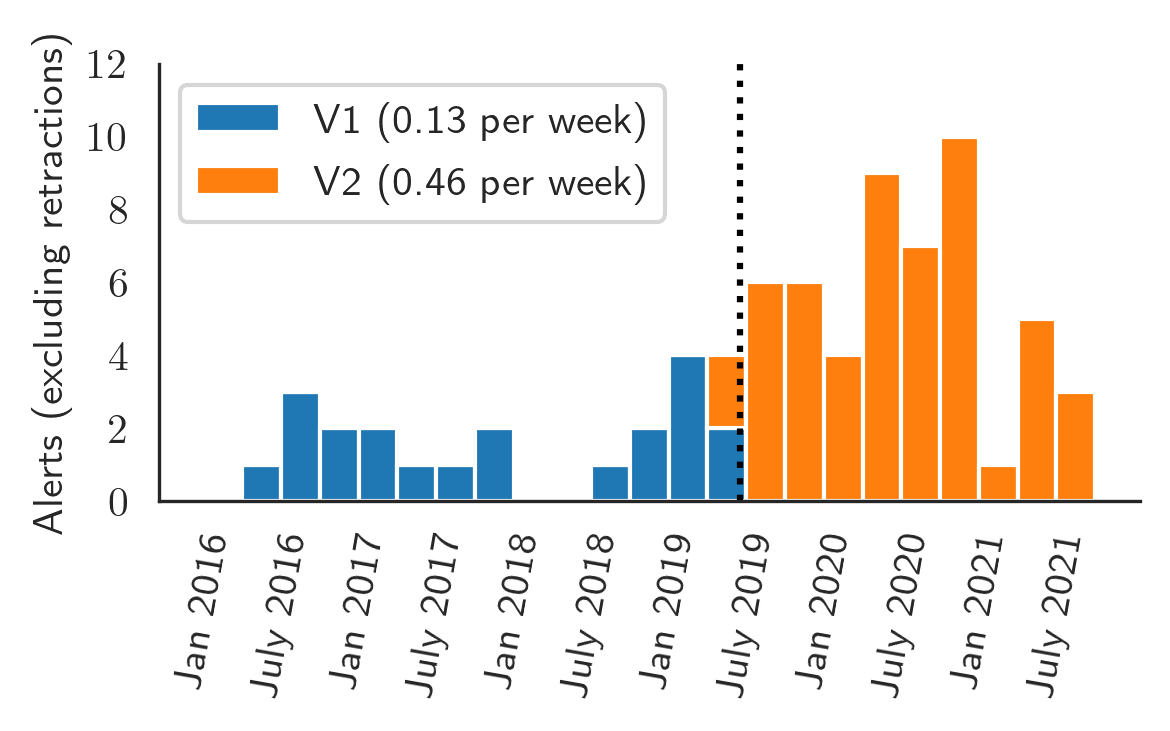

In [8]:
dates = [Time(f"20{x[2:4]}-{x[4:6]}-{x[6:8]}T00:00:01") for x in joint["Event"]]

plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

mjds = []
labs = []
bins = []

for year in range(2016, 2022):
    for k, month in enumerate([1, 4, 7, 10]):
        
        t = Time(f"{year}-{month}-01T00:00:00.01", format='isot', scale='utc').mjd
        
        bins.append(t)
        
        if (k - 1) % 2 > 0:
                    
            mjds.append(t)
            labs.append(["Jan", "July"][int(k/2)] + f" {year}")
            
t_0 = Time(f"2016-04-01T00:00:00.01", format='isot', scale='utc').mjd 
            
v1_t = Time(f"2019-06-17T00:00:00.01", format='isot', scale='utc').mjd

t_now = Time.now().mjd

alerts_v1 = [x.mjd for i, x in enumerate(dates) if np.logical_and(x.mjd < v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

alerts_v2 = [x.mjd for i, x in enumerate(dates) if np.logical_and(
    x.mjd > v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

print(f'{len(alerts_v1)} V1 alerts, {len(alerts_v2)} V2 alerts')

mod = 7.

v1_rate = mod * float(len(alerts_v1))/(v1_t - t_0)
v2_rate = mod * float(len(alerts_v2))/(t_now - v1_t)

labels = []

for (name, rate) in [("V1", v1_rate), ("V2", v2_rate)]:
    labels.append(f'{name} ({rate:.2f} per week)')
    
plt.xticks(mjds, labs, rotation=80)
plt.locator_params(axis="y", nbins=6)
plt.hist([alerts_v1, alerts_v2], bins=bins, stacked=True, label=labels)

plt.axvline(v1_t, linestyle=":", color="k")

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.legend(fontsize=big_fontsize, loc="upper left")

plt.ylabel("Alerts (excluding retractions)", fontsize=big_fontsize)

sns.despine()

plt.ylim(0., 12.)
plt.tight_layout()

filename = "alert_hist.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

9.34
21 V1 alerts, 53 V2 alerts


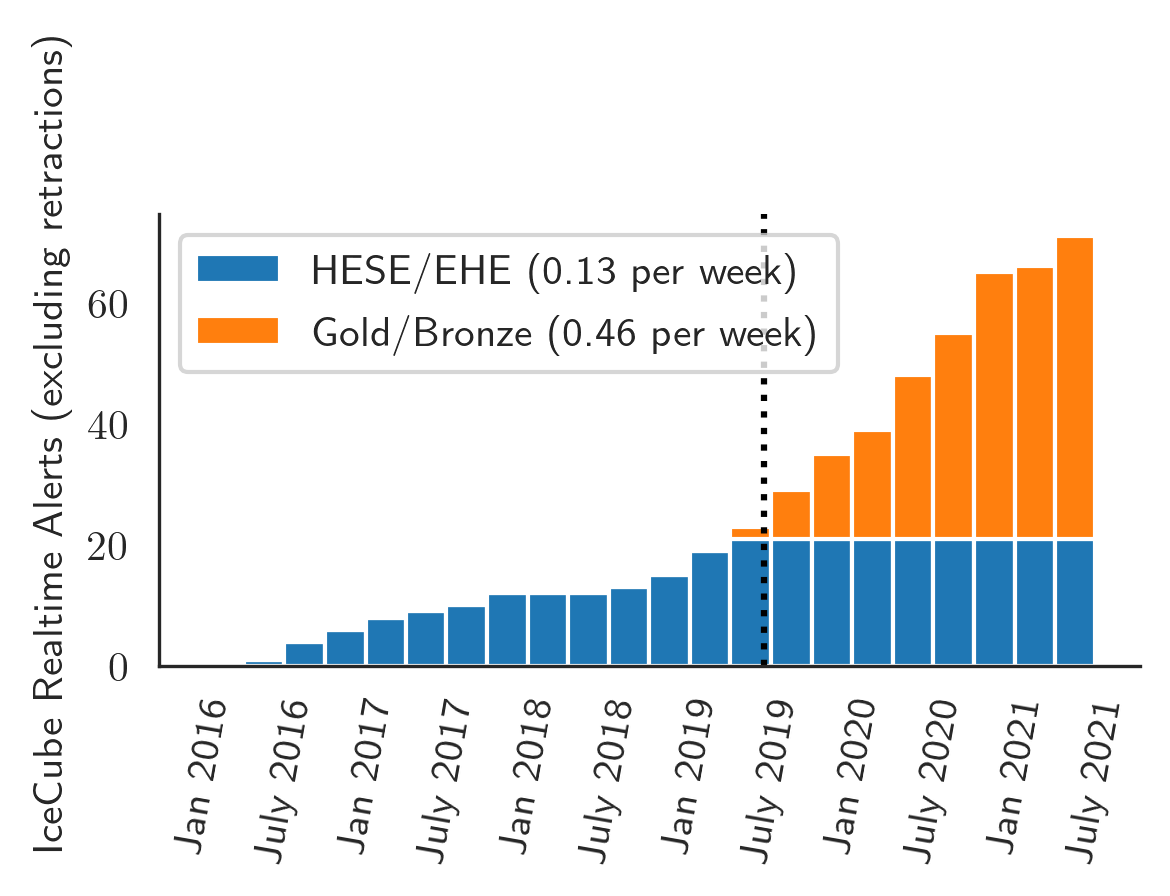

In [9]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

dates = [Time(f"20{x[2:4]}-{x[4:6]}-{x[6:8]}T00:00:01") for x in joint["Event"]]

mjds = []
labs = []
bins = []

for year in range(2016, 2022):
    for k, month in enumerate([1, 4, 7, 10]):
        
        t = Time(f"{year}-{month}-01T00:00:00.01", format='isot', scale='utc').mjd
        
        bins.append(t)
        
        if (k - 1) % 2 > 0:
                    
            mjds.append(t)
            labs.append(["Jan", "July"][int(k/2)] + f" {year}")
            
t_0 = Time(f"2016-04-01T00:00:00.01", format='isot', scale='utc').mjd 
            
v1_t = Time(f"2019-06-17T00:00:00.01", format='isot', scale='utc').mjd

t_now = Time.now().mjd

print(joint.iloc[0]["Dec"])

alerts_v1 = [x.mjd for i, x in enumerate(dates) if np.logical_and(x.mjd < v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

alerts_v2 = [x.mjd for i, x in enumerate(dates) if np.logical_and(
    x.mjd > v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

print(f'{len(alerts_v1)} V1 alerts, {len(alerts_v2)} V2 alerts')

mod = 7.

v1_rate = mod * float(len(alerts_v1))/(v1_t - t_0)
v2_rate = mod * float(len(alerts_v2))/(t_now - v1_t)

labels = []

for (name, rate) in [("HESE/EHE", v1_rate), ("Gold/Bronze", v2_rate)]:
    labels.append(f'{name} ({rate:.2f} per week)')
    
plt.xticks(mjds, labs, rotation=80)
plt.locator_params(axis="y", nbins=6)
plt.hist([alerts_v1, alerts_v2], bins=bins[:-1], stacked=True, label=labels, cumulative=True)

plt.axvline(v1_t, linestyle=":", color="k")

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.legend(fontsize=big_fontsize, loc="upper left")

sns.despine()

# plt.ylim(0., 12.)
plt.ylabel("IceCube Realtime Alerts (excluding retractions)", fontsize=big_fontsize)
plt.tight_layout()

filename = "alert_cdf.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

1 V1 alerts, 22 V2 alerts


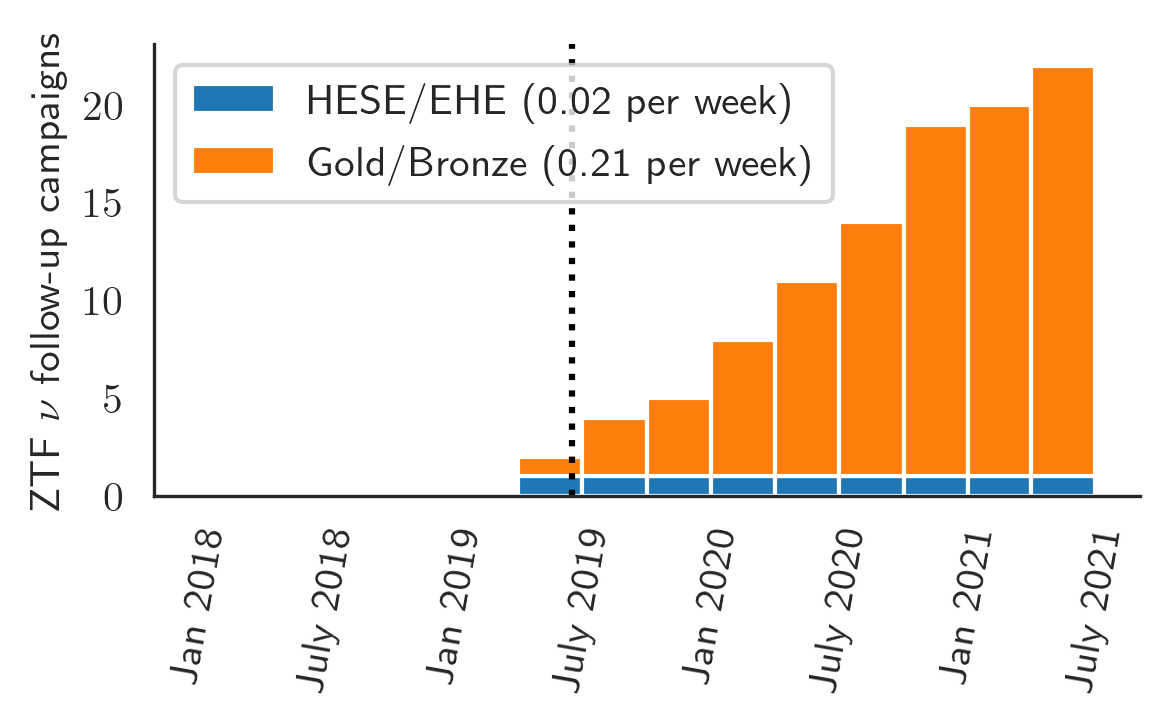

In [10]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

dates = [Time(f"20{x[2:4]}-{x[4:6]}-{x[6:8]}T00:00:01") for x in obs["Event"]]

mjds = []
labs = []
bins = []

for year in range(2018, 2022):
    for k, month in enumerate([1, 4, 7, 10]):
        
        t = Time(f"{year}-{month}-01T00:00:00.01", format='isot', scale='utc').mjd
        
        bins.append(t)
        
        if (k - 1) % 2 > 0:
                    
            mjds.append(t)
            labs.append(["Jan", "July"][int(k/2)] + f" {year}")
            
t_0 = Time(f"2018-04-01T00:00:00.01", format='isot', scale='utc').mjd 
            
v1_t = Time(f"2019-06-17T00:00:00.01", format='isot', scale='utc').mjd

t_now = Time(f"2021-07-01T00:00:00.01", format='isot', scale='utc').mjd

t_bran_cut = Time(f"2020-02-01T00:00:00.01", format='isot', scale='utc').mjd

alerts_v1 = [x.mjd for x in dates if x.mjd < v1_t]

alerts_v2 = [x.mjd for x in dates if x.mjd > v1_t]

print(f'{len(alerts_v1)} V1 alerts, {len(alerts_v2)} V2 alerts')

mod = 7.

v1_rate = mod * float(len(alerts_v1))/(v1_t - t_0)
v2_rate = mod * float(len(alerts_v2))/(t_now - v1_t)

labels = []

for (name, rate) in [("HESE/EHE", v1_rate), ("Gold/Bronze", v2_rate)]:
    labels.append(f'{name} ({rate:.2f} per week)')
    
plt.xticks(mjds, labs, rotation=80)
plt.locator_params(axis="y", nbins=6)
plt.hist([alerts_v1, alerts_v2], bins=bins[:-1], stacked=True, label=labels, cumulative=True)

plt.axvline(v1_t, linestyle=":", color="k")
# plt.axvline(t_bran_cut, linestyle="--", color="k")

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.legend(fontsize=big_fontsize, loc="upper left")

sns.despine()

# plt.ylim(0., 12.)
plt.ylabel(r"ZTF $\nu$ follow-up campaigns", fontsize=big_fontsize)
plt.tight_layout()

filename = "ztf_cdf.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [11]:
classes = list(set(joint["Class"]))

for x in classes:
    n_obs = np.sum(obs["Class"] == x)
    n_tot = np.sum(np.logical_and(joint["Class"]==x, ~np.isnan(joint["Dec"])))
    n_retracted = np.sum(np.logical_and(joint["Class"]==x, np.isnan(joint["Dec"])))
    print(f'For {x}: we have observed ({int(n_obs)}/{int(n_tot)}), or {100.*n_obs/n_tot:.1f}\%')
    print(f"There were an extra {n_retracted} events that were retracted.")
    

For BRONZE: we have observed (7/32), or 21.9\%
There were an extra 3 events that were retracted.
For EHE: we have observed (1/8), or 12.5\%
There were an extra 0 events that were retracted.
For HESE: we have observed (0/12), or 0.0\%
There were an extra 5 events that were retracted.
For HESE+EHE: we have observed (0/1), or 0.0\%
There were an extra 0 events that were retracted.
For EXTRA: we have observed (1/2), or 50.0\%
There were an extra 0 events that were retracted.
For GOLD: we have observed (14/19), or 73.7\%
There were an extra 3 events that were retracted.


In [12]:
f_det = 0.4

# sum plus assume 50% for extra
n_astro = np.sum(obs["Signalness"]) + 0.5

# n_exp 90% lower bound
n_det = 0.25

print(f'We have observed {n_astro:.2f} astrophysical neutrinos')

print(f'Two TDEs were detected, corresponding to a 90% lower bound of {n_det}')

frac_det = n_det/n_astro

print(f'This implies a minimum fraction of {100.*frac_det:.2f}% neutrinos from ZTF-detected TDEs')

frac_tot = frac_det/f_det

print(f'This implies a minimum fraction of {100.*frac_tot:.2f}% neutrinos from all TDEs')

We have observed 10.78 astrophysical neutrinos
Two TDEs were detected, corresponding to a 90% lower bound of 0.25
This implies a minimum fraction of 2.32% neutrinos from ZTF-detected TDEs
This implies a minimum fraction of 5.80% neutrinos from all TDEs


In [13]:
7800./6562.8 - 1.

0.1885170963613092

In [14]:
print(f'We have observed {tot_area:.2f} sq. deg.')

We have observed 153.16 sq. deg.


In [15]:
from scipy.stats import norm, poisson

tde_density = 2.0 * 10. ** -4. * 1.12

ztf_obs = tot_area

n_exp = tde_density * tot_area

def nexp_convert(nexp, n_det=2):
    
    cdf = poisson(nexp).cdf(n_det-1)

    p_val = 1. - cdf

    sigma = norm.ppf(cdf)
    
    return p_val, sigma

print(nexp_convert(n_exp, n_det=1))

print(nexp_convert(n_exp))

print(nexp_convert(n_exp*0.15))

print(nexp_convert(n_exp*0.3, n_det=3))

(0.033725998940380864, 1.828650396055413)
(0.0005752251158676058, 3.250888360604671)
(1.3196222315881023e-05, 4.2025504125086846)
(1.8031882598190663e-07, 5.088641493107997)


In [106]:
lim_mag = 19.5

In [128]:
p_spatial = 0.9 * (obs["Observed area (corrected for chip gaps)"]/obs['Area (rectangle)'])

s = np.array(obs["Signalness"])
s[np.isnan(s)] = 0.5

p_det = np.array(p_spatial * s).reshape(len(s), 1)

def p_no(f):
    
    p_no_i = np.ones_like(f) - p_det*f
        
    p_no_all = np.ones_like(f)
    for x in p_no_i:
        p_no_all *= x.T
    return p_no_all

x = np.linspace(0., 1., 101)
y = p_no(x)

# from scipy.interpolate import interp1d

f = interp1d(y, x)

cl = 0.9

ul = f(1.-cl)

print(f"No more than {ul*100.:.1f}% (90% CL) of neutrino sources can have a magnitude greater than our limiting magnitude of {lim_mag:.1f}")

No more than 26.2% (90% CL) of neutrino sources can have a magnitude greater than our limiting magnitude of 19.5


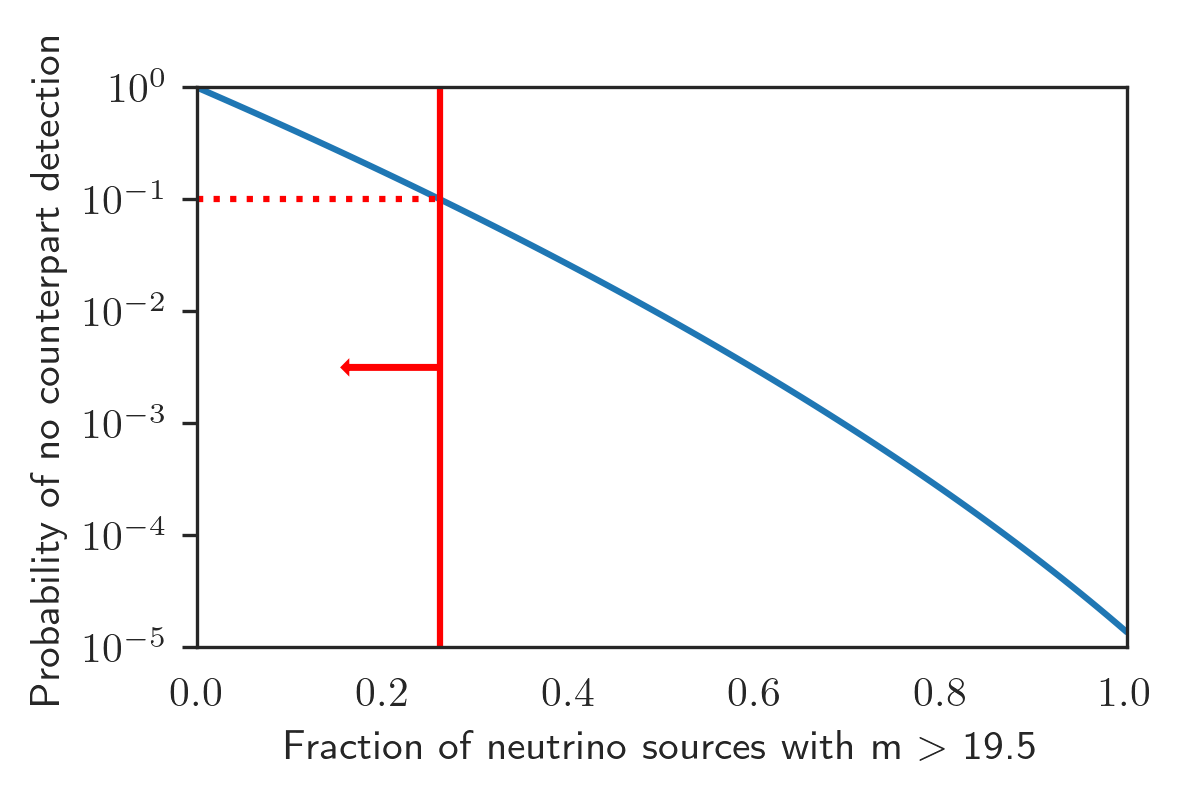

In [146]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)

ax = plt.subplot(111)

plt.plot(x, y)
plt.axvline(ul, color="r")
plt.plot([0.0, ul], [1.-cl, 1.-cl], color='r', linestyle=":")
plt.xlim(0.0, 1.0)
plt.yscale("log")

yticks = np.logspace(-5, 0, 6)

plt.ylim(yticks[0], yticks[-1])
plt.yticks(yticks)

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)

plt.xlabel(f"Fraction of neutrino sources with m $>$ {lim_mag:.1f}", fontsize=big_fontsize)
plt.ylabel("Probability of no counterpart detection", fontsize=big_fontsize)

ax2 = ax.twinx()

w = 0.3

plt.arrow(ul, 0.5, -0.1, 0.0, color="r")
plt.ylim(0.0 + w, 1.0 - w)
ax2.set_axis_off()

filename = "limit_app_mag.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [148]:
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u

def M(z):
    
    dl = cosmo.luminosity_distance(z=z).to(u.pc)
    
    ab_mag = lim_mag - 5. * np.log10(dl/(10.*u.pc))
    
    return ab_mag
    
    